# **Setup & Dependencies**

In [24]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading & Frame Building**

In [26]:
def load_and_preprocess_data(filepath, frame_size=100):
    data = pd.read_excel(filepath)

    # Normalize selected accelerometer columns
    acc_cols = ['right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]']
    scaler = StandardScaler()
    data[acc_cols] = scaler.fit_transform(data[acc_cols])

    labels = data['label'].values
    class_weights = compute_class_weights(labels)

    all_frames, all_labels = [], []

    # Segment data into fixed-size frames
    for i in range(0, len(data), frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[acc_cols].values.flatten()
        label = np.bincount(segment['label']).argmax()  # Majority label for the frame
        all_frames.append(frame)
        all_labels.append(label)

    print("Frames shape:", np.array(all_frames).shape)
    print("Labels shape:", np.array(all_labels).shape)

    return np.array(all_frames), np.array(all_labels), class_weights, data


def build_a_frame_dict(all_frames, all_labels):
    a_frame = {i: [] for i in range(all_frames.shape[1])}
    a_frame['label'] = []

    for frame, label in zip(all_frames, all_labels):
        for i, val in enumerate(frame):
            a_frame[i].append(val)
        a_frame['label'].append(label)

    return pd.DataFrame(a_frame)


def compute_class_weights(labels):
    label_counts = np.bincount(labels)
    total = len(labels)

    # Weight = total / (2 * count) to handle class imbalance
    weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]
    return torch.tensor(weights, dtype=torch.float32)


# **Dataset & DataLoader**

In [16]:
##################### XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

class IMUDataset(Dataset):
    def __init__(self, x, y):
        # Reshape input to (samples, sequence_length=100, features=3)
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 3)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def prepare_dataloaders(df, batch_size=8):
    x = df.iloc[:, :-1].values
    y = df['label'].values

    # Split into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

    train_set = IMUDataset(x_train, y_train)
    val_set = IMUDataset(x_val, y_val)

    return {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)
    }


In [27]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 3)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# **Transformer Model**

In [28]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)
        return torch.matmul(attn, v), attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attn = ScaleDotProductAttention()
        self.qkv_proj = nn.Linear(d_model, d_model * 3)  # Combine Q, K, V projections
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)
        return self.out_proj(out)


class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = 1e-6

    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.2):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Precompute sinusoidal positional encodings
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.2):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.2):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden,  drop_prob=drop_prob)
            for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransformerModel(nn.Module):
    def __init__(self, d_model=64, n_head=2, n_layers=2, seq_len=100, ffn_hidden=128, num_classes=2, drop_prob=0.2):
        super().__init__()
        self.input_proj = nn.Linear(3, d_model)  # Project 3D input to model dimension
        self.pos_enc = PositionalEncoding(d_model)
        self.encoder = Encoder(d_model, n_head, ffn_hidden, n_layers, drop_prob)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.classifier(x)


# **Training & Evaluation**

In [29]:
def calc_loss_and_score(outputs, targets, class_weights, metrics):
    # Cross-entropy loss with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss


def train_model(model, dataloaders, optimizer, class_weights, patience=10, num_epochs = 100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss_and_score(outputs, labels, class_weights, metrics)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1


            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                break

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names=None, save_path=None):
  if dataloader:
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()


def plot_metrics(history):
    # Unpack history
    epochs = range(1, len(history['val']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    # Plot loss and accuracy trends
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    #plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, train_loss[:len(epochs)], label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, train_acc[:len(epochs)], label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()


# **K-Fold Cross Validation**

In [30]:
def cross_validate_model(frames, labels, class_weights, num_classes, k=5, batch_size=8, save_dir="/content/drive/MyDrive/IMU/kfold_results"):
    os.makedirs(save_dir, exist_ok=True)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(frames, labels)):
        print(f"\n===== Fold {fold + 1} / {k} =====")

        # Split data according to stratified indices
        x_train, x_val = frames[train_idx], frames[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        # Create datasets
        train_dataset = IMUDataset(x_train, y_train)
        val_dataset = IMUDataset(x_val, y_val)

        # Create dataloaders
        dataloaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        }

        # Initialize model and optimizer
        model = TransformerModel(num_classes=num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)

        # Train the model
        model, history = train_model(model, dataloaders, optimizer, class_weights, num_epochs=100, patience=10)

        # Save model checkpoint
        model_path = os.path.join(save_dir, f"transformer_fold{fold+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model for Fold {fold+1} saved to: {model_path}")

        # Evaluate and save confusion matrix
        cm_path = os.path.join(save_dir, f"confusion_matrix_fold{fold+1}.png")
        print(f"\nEvaluation for Fold {fold + 1}")
        evaluate_and_plot_confusion_matrix(
            model=model,
            dataloader=dataloaders['val'],
            class_names=[str(i) for i in range(num_classes)],
            save_path=cm_path
        )

        # Collect fold metrics
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels_batch in dataloaders['val']:
                inputs, labels_batch = inputs.to(device), labels_batch.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_batch.cpu().numpy())

        metrics = {
            'fold': fold + 1,
            'accuracy': accuracy_score(all_labels, all_preds),
            'precision': precision_score(all_labels, all_preds, average='weighted'),
            'recall': recall_score(all_labels, all_preds, average='weighted'),
            'f1': f1_score(all_labels, all_preds, average='weighted')
        }
        all_metrics.append(metrics)

    # Average metrics over folds
    avg_metrics = {
        'fold': 'avg',
        'accuracy': np.mean([m['accuracy'] for m in all_metrics]),
        'precision': np.mean([m['precision'] for m in all_metrics]),
        'recall': np.mean([m['recall'] for m in all_metrics]),
        'f1': np.mean([m['f1'] for m in all_metrics])
    }
    all_metrics.append(avg_metrics)

    # Save all fold metrics to CSV
    df_metrics = pd.DataFrame(all_metrics)
    csv_path = os.path.join(save_dir, "kfold_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"\nAll fold metrics saved to: {csv_path}")

    # Print averaged results
    print("\n===== Cross-Validation Results (Averaged) =====")
    print(f"Accuracy : {avg_metrics['accuracy'] * 100:.2f}%")
    print(f"Precision: {avg_metrics['precision'] * 100:.2f}%")
    print(f"Recall   : {avg_metrics['recall'] * 100:.2f}%")
    print(f"F1 Score : {avg_metrics['f1'] * 100:.2f}%")

    return avg_metrics


# **Run Everything**

Frames shape: (3189, 300)
Labels shape: (3189,)

===== Fold 1 / 5 =====

Epoch 1/100
------------------------------
Train Loss: 0.6675 | Accuracy: 60.17%
 Best model updated!
Val Loss: 0.6557 | Accuracy: 61.13%

Epoch 2/100
------------------------------
Train Loss: 0.6259 | Accuracy: 65.93%
 Best model updated!
Val Loss: 0.6139 | Accuracy: 68.18%

Epoch 3/100
------------------------------
Train Loss: 0.6057 | Accuracy: 68.76%
 Best model updated!
Val Loss: 0.5757 | Accuracy: 70.22%

Epoch 4/100
------------------------------
Train Loss: 0.5858 | Accuracy: 70.01%
 Best model updated!
Val Loss: 0.5454 | Accuracy: 69.91%

Epoch 5/100
------------------------------
Train Loss: 0.5593 | Accuracy: 72.32%
 Best model updated!
Val Loss: 0.5147 | Accuracy: 75.24%

Epoch 6/100
------------------------------
Train Loss: 0.5212 | Accuracy: 75.30%
Val Loss: 0.5216 | Accuracy: 75.71%

Epoch 7/100
------------------------------
Train Loss: 0.4886 | Accuracy: 76.48%
 Best model updated!
Val Loss: 0.

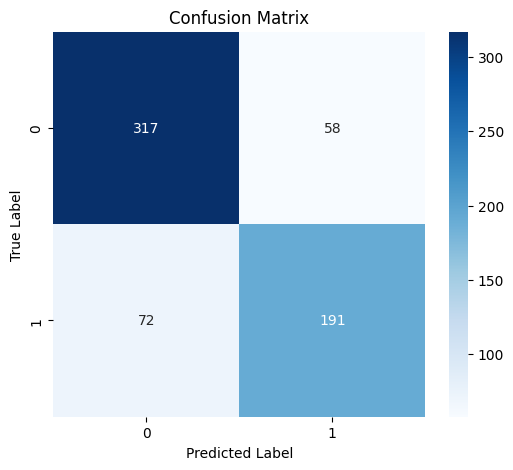


===== Fold 2 / 5 =====

Epoch 1/100
------------------------------
Train Loss: 0.6619 | Accuracy: 62.49%
 Best model updated!
Val Loss: 0.6941 | Accuracy: 58.62%

Epoch 2/100
------------------------------
Train Loss: 0.6193 | Accuracy: 66.29%
 Best model updated!
Val Loss: 0.6228 | Accuracy: 66.14%

Epoch 3/100
------------------------------
Train Loss: 0.5929 | Accuracy: 69.38%
 Best model updated!
Val Loss: 0.5792 | Accuracy: 70.85%

Epoch 4/100
------------------------------
Train Loss: 0.5659 | Accuracy: 71.42%
Val Loss: 0.6307 | Accuracy: 68.50%

Epoch 5/100
------------------------------
Train Loss: 0.5540 | Accuracy: 71.85%
Val Loss: 0.6787 | Accuracy: 68.18%

Epoch 6/100
------------------------------
Train Loss: 0.5232 | Accuracy: 74.60%
Val Loss: 0.6789 | Accuracy: 70.22%

Epoch 7/100
------------------------------
Train Loss: 0.5100 | Accuracy: 75.03%
Val Loss: 0.6201 | Accuracy: 71.16%

Epoch 8/100
------------------------------
Train Loss: 0.4702 | Accuracy: 77.07%
Val L

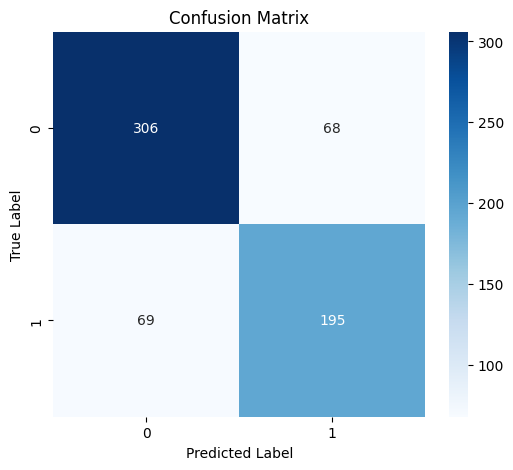


===== Fold 3 / 5 =====

Epoch 1/100
------------------------------
Train Loss: 0.6785 | Accuracy: 61.00%
 Best model updated!
Val Loss: 0.5732 | Accuracy: 70.22%

Epoch 2/100
------------------------------
Train Loss: 0.6313 | Accuracy: 64.92%
 Best model updated!
Val Loss: 0.5713 | Accuracy: 70.85%

Epoch 3/100
------------------------------
Train Loss: 0.6041 | Accuracy: 69.15%
 Best model updated!
Val Loss: 0.5475 | Accuracy: 72.88%

Epoch 4/100
------------------------------
Train Loss: 0.5862 | Accuracy: 69.62%
 Best model updated!
Val Loss: 0.5366 | Accuracy: 75.55%

Epoch 5/100
------------------------------
Train Loss: 0.5677 | Accuracy: 71.27%
Val Loss: 0.6003 | Accuracy: 68.81%

Epoch 6/100
------------------------------
Train Loss: 0.5392 | Accuracy: 72.76%
 Best model updated!
Val Loss: 0.5055 | Accuracy: 74.76%

Epoch 7/100
------------------------------
Train Loss: 0.4993 | Accuracy: 75.07%
 Best model updated!
Val Loss: 0.4834 | Accuracy: 77.43%

Epoch 8/100
-----------

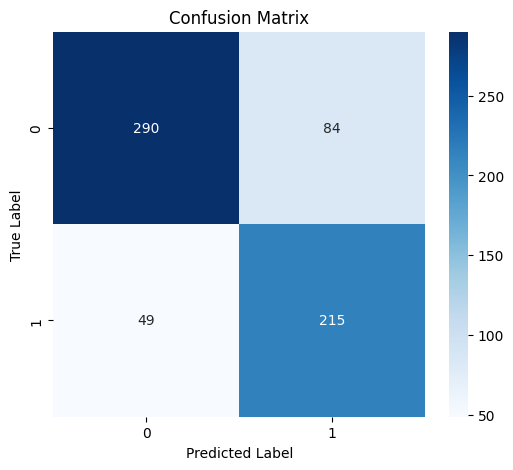


===== Fold 4 / 5 =====

Epoch 1/100
------------------------------
Train Loss: 0.6731 | Accuracy: 60.25%
 Best model updated!
Val Loss: 0.7879 | Accuracy: 58.15%

Epoch 2/100
------------------------------
Train Loss: 0.6243 | Accuracy: 66.21%
 Best model updated!
Val Loss: 0.6286 | Accuracy: 65.99%

Epoch 3/100
------------------------------
Train Loss: 0.5934 | Accuracy: 69.78%
Val Loss: 0.6839 | Accuracy: 58.93%

Epoch 4/100
------------------------------
Train Loss: 0.5672 | Accuracy: 71.54%
 Best model updated!
Val Loss: 0.6036 | Accuracy: 71.94%

Epoch 5/100
------------------------------
Train Loss: 0.5255 | Accuracy: 73.85%
 Best model updated!
Val Loss: 0.5422 | Accuracy: 74.29%

Epoch 6/100
------------------------------
Train Loss: 0.4670 | Accuracy: 77.97%
Val Loss: 0.5705 | Accuracy: 74.76%

Epoch 7/100
------------------------------
Train Loss: 0.4404 | Accuracy: 78.20%
 Best model updated!
Val Loss: 0.4892 | Accuracy: 76.96%

Epoch 8/100
------------------------------
T

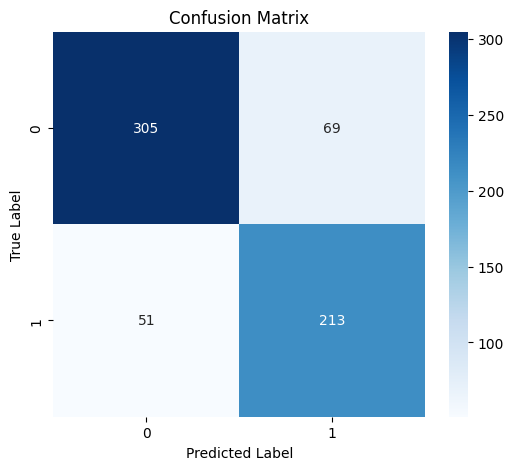


===== Fold 5 / 5 =====

Epoch 1/100
------------------------------
Train Loss: 0.6625 | Accuracy: 61.68%
 Best model updated!
Val Loss: 0.6207 | Accuracy: 66.56%

Epoch 2/100
------------------------------
Train Loss: 0.6224 | Accuracy: 67.08%
 Best model updated!
Val Loss: 0.6151 | Accuracy: 66.09%

Epoch 3/100
------------------------------
Train Loss: 0.5999 | Accuracy: 68.81%
Val Loss: 0.6180 | Accuracy: 67.19%

Epoch 4/100
------------------------------
Train Loss: 0.5888 | Accuracy: 70.57%
 Best model updated!
Val Loss: 0.5724 | Accuracy: 70.96%

Epoch 5/100
------------------------------
Train Loss: 0.5672 | Accuracy: 71.32%
Val Loss: 0.7592 | Accuracy: 65.62%

Epoch 6/100
------------------------------
Train Loss: 0.5312 | Accuracy: 73.35%
 Best model updated!
Val Loss: 0.5325 | Accuracy: 72.37%

Epoch 7/100
------------------------------
Train Loss: 0.4852 | Accuracy: 77.19%
 Best model updated!
Val Loss: 0.5124 | Accuracy: 75.35%

Epoch 8/100
------------------------------
T

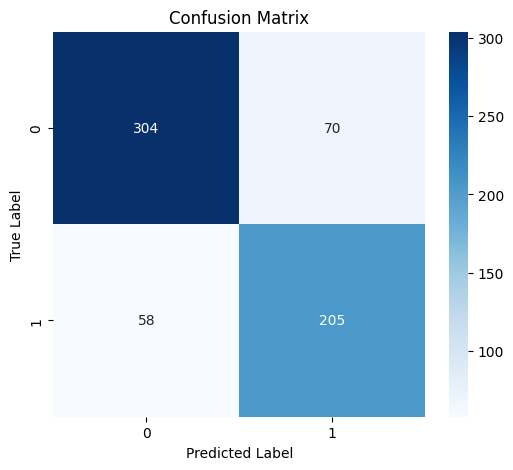


All fold metrics saved to: /content/drive/MyDrive/IMU/kfold_results/kfold_metrics.csv

===== Cross-Validation Results (Averaged) =====
Accuracy : 79.68%
Precision: 79.90%
Recall   : 79.68%
F1 Score : 79.72%


{'fold': 'avg',
 'accuracy': np.float64(0.7968022125657594),
 'precision': np.float64(0.7989930317718428),
 'recall': np.float64(0.7968022125657594),
 'f1': np.float64(0.7971558680356439)}

In [31]:
# Load and preprocess raw IMU data
file_path = "/content/drive/MyDrive/IMU/combined_data.xlsx"
frames, labels, class_weights, raw_data = load_and_preprocess_data(file_path)

# Sanity check
assert len(frames) == len(labels), f"Mismatch: {len(frames)} frames vs {len(labels)} labels"

# Convert framed data into a DataFrame format for training
df = build_a_frame_dict(frames, labels)
num_classes = len(np.unique(labels))


cross_validate_model(
    frames=frames,
    labels=labels,
    class_weights=class_weights,
    num_classes=num_classes,
    k=5,
    batch_size=8,
    save_dir="/content/drive/MyDrive/IMU/kfold_results"
)

In [ ]:
# Load and preprocess raw IMU data
file_path = "/content/drive/MyDrive/IMU/combined_data.xlsx"
frames, labels, class_weights, raw_data = load_and_preprocess_data(file_path)

# Convert framed data into a DataFrame format for training
df = build_a_frame_dict(frames, labels)
num_classes = len(np.unique(labels))

# Prepare dataloaders
dataloaders = prepare_dataloaders(df, batch_size=8)

# Initialize model and optimizer
model = TransformerModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Train the model
trained_model, history = train_model(
    model,
    dataloaders,
    optimizer,
    class_weights,
    num_epochs=100,
    patience=10,
)

# Plot training/validation metrics
plot_metrics(history)

# Evaluate final model performance and save confusion matrix
evaluate_and_plot_confusion_matrix(
    trained_model,
    dataloaders['val'],
    class_names=[str(i) for i in range(num_classes)],
    save_path="/content/drive/MyDrive/IMU/confusion_matrix.png"
)

# Save the trained model
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/IMU/transformer_model_gaitAnalysis.pth")
